In [1]:
import boto3
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from ipywidgets import IntProgress
from ignite.metrics import Accuracy
from sklearn.metrics import balanced_accuracy_score,confusion_matrix, precision_score, recall_score, f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [5]:
sys.path.append("../src")

In [6]:
from Dataset import VideoDatasetAprox1, LocalVideoDatasetAprox1, VideoDatasetAprox2, LocalVideoDatasetAprox2, VideoDatasetAprox3, VideoDatasetAprox4, LocalVideoDatasetAprox3, LocalVideoDatasetAprox4
from Model import ModelAprox1, ModelAprox2, ModelAprox3, ModelAprox4, ModelAprox5
from Model import ModelAprox6, ModelAprox7, ModelAprox8, ModelAprox9, ModelAprox10
from Model import ModelAprox11, ModelAprox12, ModelAprox13, ModelAprox14, ModelAprox15
from Model import ModelAprox16, ModelAprox17, ModelAprox18, ModelAprox19

## **Evaluación modelo 1 ( RNN con audio como input)**

In [7]:
dataset = LocalVideoDatasetAprox3(set_selected="val")

In [8]:
print("Dataset con %d instancias con las que poder trabajar"%(len(dataset)))

Dataset con 20052 instancias con las que poder trabajar


In [9]:
BATCH_SIZE = 1
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# Construimos el modelo correspondiente
model = torch.load("model23")
# Llevamos el modelo al dispositivo que lo procesará
model.cuda()

ModelAprox19(
  (BatchPredictionWaveNet): BatchPredictionWaveNet(
    (causalInputConvolution): CausalInputConvolution(
      (causal_convolution): Conv1d(256, 16, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
    )
    (waveNetStack): WaveNetStack()
    (outputModule): OutputModuleX2(
      (deconvolution1): ConvTranspose1d(256, 256, kernel_size=(2,), stride=(2,))
      (deconvolution2): ConvTranspose1d(256, 256, kernel_size=(2,), stride=(1,))
      (relu): ReLU()
      (convolution1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (convolution2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (softmax): Softmax(dim=1)
    )
  )
)

**Evaluación sencilla**

In [11]:
%%time
total_balanced_accuracy = 0
total_micro_precision = 0
total_micro_recall = 0
total_micro_f_score = 0
total_macro_precision = 0
total_macro_recall = 0
total_macro_f_score = 0
contador=0
for batch in iter(dataloader):
    with torch.no_grad():
        audio = batch
        input_seq = nn.functional.one_hot(audio.long(), num_classes=256)
        target_seq = audio.view(-1).long()[1:]
        target_seq = torch.cat((target_seq, torch.zeros(1)), 0).long()
        target_seq = target_seq.resize_((BATCH_SIZE,80000))
        target_seq = target_seq[:,-70000:]
        output = model(input_seq.cuda())
        output = torch.argmax(output, dim=1)
        for i in range(BATCH_SIZE):
            y_true = target_seq[i].cpu()
            y_pred = output[i].cpu()
            total_balanced_accuracy += balanced_accuracy_score(y_true,y_pred)
            total_micro_precision += precision_score(y_true,y_pred, average="micro")
            total_micro_recall += recall_score(y_true,y_pred, average="micro")
            total_micro_f_score += f1_score(y_true,y_pred, average="micro")
            total_macro_precision += precision_score(y_true,y_pred, average="macro")
            total_macro_recall += recall_score(y_true,y_pred, average="macro")
            total_macro_f_score += f1_score(y_true,y_pred, average="macro")
        contador+=BATCH_SIZE
        if contador%1000==0:
            print("Batch..............%d/20000"%(contador))

invalid new backstep -1


Batch..............1000/20000
Batch..............2000/20000
Batch..............3000/20000
Batch..............4000/20000
Batch..............5000/20000
Batch..............6000/20000
Batch..............7000/20000
Batch..............8000/20000
Batch..............9000/20000
Batch..............10000/20000
Batch..............11000/20000
Batch..............12000/20000
Batch..............13000/20000
Batch..............14000/20000
Batch..............15000/20000
Batch..............16000/20000
Batch..............17000/20000
Batch..............18000/20000
Batch..............19000/20000
Batch..............20000/20000
CPU times: user 2h 35min 43s, sys: 35min 10s, total: 3h 10min 53s
Wall time: 2h 30min 49s


In [13]:
print("Balanced accuracy:",total_balanced_accuracy/(len(dataloader)*BATCH_SIZE))
print("Micro precision:",total_micro_precision/(len(dataloader)*BATCH_SIZE))
print("Micro recall:",total_micro_recall/(len(dataloader)*BATCH_SIZE))
print("Micro f-score:",total_micro_f_score/(len(dataloader)*BATCH_SIZE))
print("Macro precision:",total_macro_precision/(len(dataloader)*BATCH_SIZE))
print("Macro recall:",total_macro_recall/(len(dataloader)*BATCH_SIZE))
print("Macro f-score:",total_macro_f_score/(len(dataloader)*BATCH_SIZE))

Balanced accuracy: 0.016563055492428216
Micro precision: 0.020982111510073894
Micro recall: 0.020982111510073894
Micro f-score: 0.020982111510073894
Macro precision: 0.0009954452820146026
Macro recall: 0.016544148553358874
Macro f-score: 0.0016819182286472605


In [8]:
# Construimos el modelo correspondiente
model = torch.load("model23")
# Llevamos el modelo al dispositivo que lo procesará

In [9]:
import time
def evaluation(dataloader):
    total_balanced_accuracy = 0
    total_micro_precision = 0
    total_micro_recall = 0
    total_micro_f_score = 0
    total_macro_precision = 0
    total_macro_recall = 0
    total_macro_f_score = 0
    contador = 0
    for batch in dataloader:
        contador+=BATCH_SIZE
        audio = batch
        input_seq = nn.functional.one_hot(audio.long(), num_classes=256)
        target_seq = audio.view(-1).long()[1:]
        target_seq = torch.cat((target_seq, torch.zeros(1)), 0).long()
        target_seq = target_seq.resize_((BATCH_SIZE,80000))
        target_seq = target_seq[:,-70000:]
        target_seq = target_seq
        #target_seq = target_seq
        values_generated = input_seq.cuda()
        n_value = 70000
        with torch.no_grad():
            for value in range(0,4001):
                if n_value>70000:
                    values_generated = torch.cat((values_generated[:,1:,:],output1[:,None].cuda()), 1)
                    values_generated = torch.cat((values_generated[:,1:,:],output2[:,None].cuda()), 1)
                #value = values_generated[None,:]
                output = model(values_generated).cpu()
                output2 = output[:,:,-1]
                output1 = output[:,:,-2]
                n_value+=2
                if n_value%1000==0:
                    print(n_value)
            for i in range(BATCH_SIZE):
                y_true = target_seq[i].cpu()
                y_pred = values_generated[:,-70000:,:].cpu()
                y_pred = torch.argmax(y_pred, dim=2)[0,:]
                total_balanced_accuracy += balanced_accuracy_score(y_true,y_pred)
                total_micro_precision += precision_score(y_true,y_pred, average="micro")
                total_micro_recall += recall_score(y_true,y_pred, average="micro")
                total_micro_f_score += f1_score(y_true,y_pred, average="micro")
                total_macro_precision += precision_score(y_true,y_pred, average="macro")
                total_macro_recall += recall_score(y_true,y_pred, average="macro")
                total_macro_f_score += f1_score(y_true,y_pred, average="macro")
            print("Balanced accuracy:",total_balanced_accuracy/contador)
            print("Micro precision:",total_micro_precision/contador)
            print("Micro recall:",total_micro_recall/contador)
            print("Micro f-score:",total_micro_f_score/contador)
            print("Macro precision:",total_macro_precision/contador)
            print("Macro recall:",total_macro_recall/contador)
            print("Macro f-score:",total_macro_f_score/contador)
        if contador==1:
            return y_true,y_pred

In [10]:
BATCH_SIZE = 1
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
%%time
y_true, y_pred = evaluation(dataloader)

71000
72000
73000
74000
75000
76000
77000
78000
Balanced accuracy: 0.005906936954230784
Micro precision: 0.009257142857142858
Micro recall: 0.009257142857142858
Micro f-score: 0.009257142857142858
Macro precision: 0.006119910615788919
Macro recall: 0.005906936954230784
Macro f-score: 0.005594647564600724
CPU times: user 9min 46s, sys: 1min 3s, total: 10min 49s
Wall time: 10min 50s


NameError: name 'values_generated' is not defined

In [38]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame({"value": [i[0] for i in list(y_pred.numpy())]}).reset_index()

NameError: name 'y_pred' is not defined

In [10]:
contador=0
for batch in dataloader:
    if contador%1000==0:
        print(contador)
    contador+=1

0


invalid new backstep -1


1000


In [30]:
import pandas as pd
import plotly.express as px
df = pd.read_csv("y_true.csv")

In [29]:
df.head()

,index,value
0,0,40.0
1,1,41.0
2,2,46.0
3,3,41.0
4,4,45.0


In [31]:
df.head()

,index,value
0,0,41
1,1,46
2,2,41
3,3,45
4,4,45


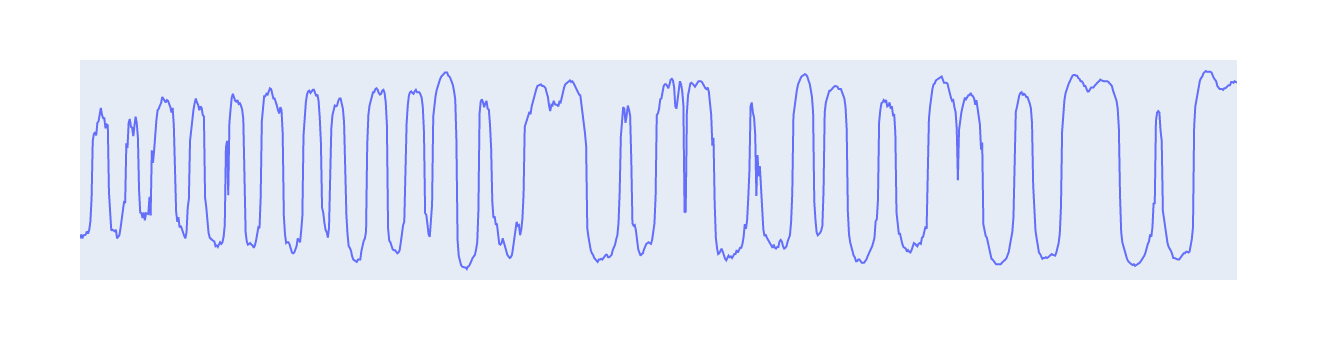

In [25]:
fig = px.line(df.iloc[:1000,:], x="index", y="value")
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

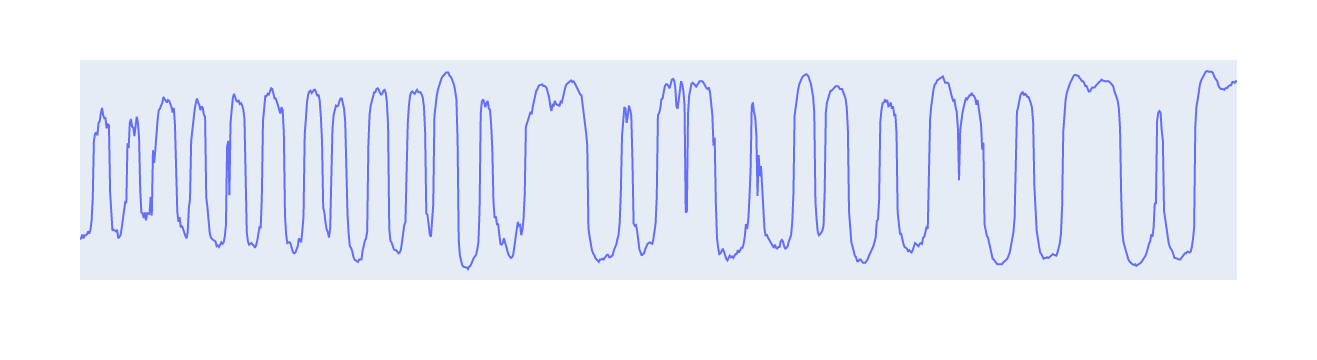

In [25]:
fig = px.line(df.iloc[:1000,:], x="index", y="value")
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

In [31]:
df

,index,value
0,0,41
1,1,46
2,2,41
3,3,45
4,4,45
...,...,...
79995,79995,58
79996,79996,63
79997,79997,59
79998,79998,43


In [ ]:
def evaluation(dataloader):
    total_balanced_accuracy = 0
    total_micro_precision = 0
    total_micro_recall = 0
    total_micro_f_score = 0
    total_macro_precision = 0
    total_macro_recall = 0
    total_macro_f_score = 0
    contador = 0
    for batch in dataloader:
        contador+=BATCH_SIZE
        input_seq = batch[0]
        target_seq = input_seq.view(-1).long()[1:]
        target_seq = torch.cat((target_seq, torch.tensor([float(target_seq[-1].numpy())])), 0).long()
        target_seq = target_seq.reshape(BATCH_SIZE,int(target_seq.shape[0]/BATCH_SIZE))
        #target_seq = target_seq
        values_generated = input_seq[:,:72000]
        n_value = 72000
        for value in range(0,8001):
            if n_value>72000:
                values_generated = torch.cat((values_generated.cuda(),output.cuda()[:,None]), 1)
            #value = values_generated[None,:]
            output = model((values_generated,batch[1][:len(values_generated)]))
            output = output.reshape(BATCH_SIZE,int(output.shape[0]/BATCH_SIZE),256)
            output = torch.argmax(output[:,-1,:], dim=1)
            output = torch.tensor([(output[:,None].cpu().numpy())])[0,:,:]
            n_value+=1
            if n_value%1000==0:
                print(n_value)
        for i in range(BATCH_SIZE):
            y_true = target_seq[i]
            y_pred = values_generated[i].cpu()
            total_balanced_accuracy += balanced_accuracy_score(y_true,y_pred)
            total_micro_precision += precision_score(y_true,y_pred, average="micro")
            total_micro_recall += recall_score(y_true,y_pred, average="micro")
            total_micro_f_score += f1_score(y_true,y_pred, average="micro")
            total_macro_precision += precision_score(y_true,y_pred, average="macro")
            total_macro_recall += recall_score(y_true,y_pred, average="macro")
            total_macro_f_score += f1_score(y_true,y_pred, average="macro")
        print("Balanced accuracy:",total_balanced_accuracy/contador)
        print("Micro precision:",total_micro_precision/contador)
        print("Micro recall:",total_micro_recall/contador)
        print("Micro f-score:",total_micro_f_score/contador)
        print("Macro precision:",total_macro_precision/contador)
        print("Macro recall:",total_macro_recall/contador)
        print("Macro f-score:",total_macro_f_score/contador)
        if contador==1:
            return y_true,y_pred